# Notebook is connected to c3.8xlarge AWS instance

In [1]:
# free memory in GiB
!free -g

             total       used       free     shared    buffers     cached
Mem:            58         20         37          0          0         19
-/+ buffers/cache:          1         57
Swap:            0          0          0


In [2]:
# number of processors
!cat /proc/cpuinfo | grep processor| wc -l

32


In [3]:
# check size of disk
!df -h | head -n 2

Filesystem      Size  Used Avail Use% Mounted on
/dev/xvda1       99G   22G   73G  24% /


In [ ]:
# this script takes around an hour to download all data. should be augmented to be async in the future
# NOTE: not going to re-run since I have the data
!mkdir data
!mkdir info

!wget --accept txt,xls \
     --mirror \
     --progress=dot \
     --adjust-extension \
     --convert-links \
     --backup-converted \
     --no-parent \
     http://web.mta.info/developers/turnstile.html

!mv web.mta.info/developers/data/nyct/turnstile/* data
!mv web.mta.info/developers/resources/nyct/turnstile/* info
!rm -rf web.mta.info

# make sure you sudo apt-get install catdoc
!xls2csv info/Remote-Booth-Station.xls > info/Remote-Booth-Station.csv

# Format Old and New Data Into Common Format

### Create function for helping us lookup missing stations in pre-oct-2014 datasets

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np

# create station-information lookup dict based on C/A and Unit
cols_stations = ['UNIT','CA', 'STATION', 'LINENAME', 'DIVISION']
df_stations_lookup = pd.read_csv("info/Remote-Booth-Station.csv", header=None, names=cols_stations)

keys = df_stations_lookup.CA + df_stations_lookup.UNIT
values = df_stations_lookup.loc[:,['STATION','LINENAME','DIVISION']].to_dict('records')

station_lookup = dict(zip(keys,values))
# example: 'B010R412': {'DIVISION': 'BMT','LINENAME': 'S2345','STATION': 'BOTANIC GARDEN'}

def lookup(key, col):
    '''lookup function to use with pandas to which you can partially apply which key you'd like to lookup'''
    try:
        return station_lookup[key][col]
    except KeyError as err:
        return np.nan

### Define some column vars to help us with data munging

In [2]:
cols_old = [
    'CA','UNIT','SCP',
    'DATE1','TIME1','DESC1','ENTRIES1','EXITS1',
    'DATE2','TIME2','DESC2','ENTRIES2','EXITS2',
    'DATE3','TIME3','DESC3','ENTRIES3','EXITS3',
    'DATE4','TIME4','DESC4','ENTRIES4','EXITS4',
    'DATE5','TIME5','DESC5','ENTRIES5','EXITS5',
    'DATE6','TIME6','DESC6','ENTRIES6','EXITS6',
    'DATE7','TIME7','DESC7','ENTRIES7','EXITS7',
    'DATE8','TIME8','DESC8','ENTRIES8','EXITS8']
cols_new = [
    'CA','UNIT','SCP', 'STATION','LINENAME','DIVISION',
    'DATE','TIME','DESC','ENTRIES','EXITS']
cols_final = cols_new + ['DATETIME']

### New turnstile files don't need much re-formatting but we do want to add a DATETIME column

In [3]:
def read_new(filename):
    '''read new-MTA-format file into pandas.dataframe'''
    df = pd.read_csv(filename, header=1, names=cols_new)
    # parse date and time into DAY and DATETIME
    datetime = df.DATE + ' ' + df.TIME
    df['DATETIME'] = pd.to_datetime(datetime, format='%m/%d/%Y %H:%M:%S')
    return df

### Old turnstile data files however have a much different format and pack multiple datapoints on individual lines that need to be broken up to one datapoint per line

In [4]:
def read_old(filename):
    '''read old-MTA-format file into pandas.dataframe. returns dataframe in new-MTA-format'''
    # use old column names defined in ts_Field_Description_pre-10-18-2014.txt
    df_old = pd.read_csv(filename, header=None, names=cols_old)

    # add missing station-information columns
    station_lookup_keys = df_old.CA + df_old.UNIT
    df_old['STATION']  = station_lookup_keys.apply(lookup, col='STATION')
    df_old['LINENAME'] = station_lookup_keys.apply(lookup, col='LINENAME')
    df_old['DIVISION'] = station_lookup_keys.apply(lookup, col='DIVISION')

    def extract_column_range(i):
        '''not every row has all columns filled so this function pulls out 
        those rows who are not null for col 'i', and pre-pends CA,UNIT,SCP'''
        c = str(i)
        cols_select = ['CA','UNIT','SCP','STATION','LINENAME','DIVISION',
            'DATE'+c,'TIME'+c,'DESC'+c,'ENTRIES'+c,'EXITS'+c]
        df_notnull = df_old[df_old['DATE'+c].notnull()].loc[:,cols_select]
        # re-name columns to new-MTA-format
        df_notnull.columns = cols_new
        return df_notnull

    # restructure old format data to have one data point per row
    df_restructured = pd.concat(extract_column_range(i) for i in range(1,9)) 

    # make DATETIME column from date and time columns 
    datetime = df_restructured.DATE + ' ' + df_restructured.TIME
    df_restructured['DATETIME'] = pd.to_datetime(datetime, format='%m-%d-%y %H:%M:%S', errors='coerce')

    # reorder columns to final output format
    df_restructured = df_restructured.loc[:,cols_final]
    return df_restructured

### Load and reformat raw turnstile data, old and new, and save the reformatted dataframes out to disk
### Note: saving common-format dataframes to disk allows us to skip this costly step in the future if we mess up

In [5]:
import os, glob

def save_df(df, filename, directory):
    '''save dataframe as pickled obj to a directory'''
    # make dir if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
    # construct the output filename
    basename = os.path.basename(filename)
    outname = os.path.join(directory, basename)
    # save pickled dataframe
    df.to_pickle(outname)
     
def is_old_format(filename):
    return os.path.basename(filename) < 'turnstile_141018.txt'

def reformat_and_save(f):
    '''Read in and reformat raw data. save common-format dataframes to reformatted directory'''
    # print('old' if is_old_format(f) else 'new', f)
    df = read_old(f) if is_old_format(f) else read_new(f)
    save_df(df, f, 'reformatted')

In [ ]:
# grab all raw turnstile files from data/
turnstile_files = glob.glob(os.path.join('data', '*.txt'))

# take advantage of all cores re-formatting turnstile files
import multiprocessing
cores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(cores)

# in parallel, reformat and save intermediate-format turnstile files
# we can ignore the DTypeWarnings
pool.map(reformat_and_save, turnstile_files)
pool.close()
pool.join()

# Augment the formatted data with information that will make analysis and modeling easier

In [6]:
import glob, os

# read all common-format data in one dataframe 
reformatted_files = glob.glob(os.path.join('reformatted', '*.txt'))

In [7]:
df = pd.concat(pd.read_pickle(f) for f in reformatted_files)

### Cast from object type to numeric

In [8]:
df['EXITS'] = pd.to_numeric(df.EXITS, errors='coerce')
df['ENTRIES'] = pd.to_numeric(df.ENTRIES, errors='coerce')
df.dtypes

CA                  object
UNIT                object
SCP                 object
STATION             object
LINENAME            object
DIVISION            object
DATE                object
TIME                object
DESC                object
ENTRIES            float64
EXITS              float64
DATETIME    datetime64[ns]
dtype: object

### I discovered through manual inspection that many STATIONS removed the 'E' in 'AVE' after the switch to the new format so let's fix that first

In [28]:
stations_to_rename = { station: station+'E' for station in [
    '1 AV', '18 AV', '2 AV', '20 AV', '25 AV', '3 AV', '57 ST-7 AV', '6 AV',
    '67 AV', '7 AV', '75 AV', '8 AV', '9 AV', 'ALABAMA AV', 'ALLERTON AV',
    'ATLANTIC AV', 'BAY PKY-22 AV', 'BAY RIDGE AV', 'BAYCHESTER AV', 'BEDFORD AV',
    'BEEBE-39 AV', 'BROOK AV', 'BUHRE AV', 'BURKE AV', 'BURNSIDE AV',
    'BUSHWICK AV', 'CASTLE HILL AV', 'CENTRAL AV', 'CHURCH AV', 'CLASSON AV',
    'CYPRESS AV', 'DEKALB AV', 'DITMAS AV', 'ELDER AV', 'ELMHURST AV',
    'EUCLID AV', 'FLUSHING AV', 'FOREST AV', 'FRANKLIN AV', 'GATES AV',
    'GRAHAM AV', 'GRANT AV', 'GREENPOINT AV', 'HUNTERS PT AV', 'HUNTS POINT AV',
    'JACKSON AV', 'KINGSTON AV', 'LAFAYETTE AV', 'LIBERTY AV', 'LIVONIA AV',
    'LONGWOOD AV', 'MARCY AV', 'MONTROSE AV', 'MORGAN AV', 'MT EDEN AV',
    'MYRTLE AV', 'NEPTUNE AV', 'NEREID AV', 'NEW LOTS AV', 'NEW UTRECHT AV',
    'NEWKIRK AV', 'NORWOOD AV', 'NOSTRAND AV', 'PARKSIDE AV', 'PROSPECT AV',
    'RALPH AV', 'ROCKAWAY AV', 'SARATOGA AV', 'SHEPHERD AV', 'ST LAWRENCE AV',
    'SUTTER AV', 'TREMONT AV', 'UTICA AV', 'VAN SICLEN AV', 'WHITLOCK AV',
    'WILSON AV', 'ZEREGA AV'
]}

### There were other columns that give me grief as well that I found by rigorously digging through the data. The STATION name change happened Dec 26, 2015

In [30]:
stations_to_rename.update({
    'AVENUE H': 'AVE H',
    'AVE J': 'AVENUE J',
    'AVE M': 'AVENUE M',
    'AVE N': 'AVENUE N',
    'AVE P': 'AVENUE P',
    'AVE U': 'AVENUE U',
    'AVE X': 'AVENUE X',
    'AVENUE I': 'AVE I',
    'AQUEDUCT N.COND': 'AQUEDUCT-N CNDT',
    '137 ST CITY COL': '137 ST-CITY COL',
    'ASTOR PL': 'ASTOR PLACE',
    '52 ST': '52 ST-LINCOLN',
    'PELHAM PARKWAY': 'PELHAM PKWY',
    'NORWOOD 205 ST': 'NORWOOD-205 ST',
    'GRD CNTRL-42 ST': '42 ST-GRD CNTRL',
    'WAKEFIELD-241': 'WAKEFIELD/241',
    'INTERVALE AV': 'INTERVALE-163',
    'HOWARD BCH JFK': 'HOWARD BCH-JFK',
    'WHITEHALL S-FRY': 'WHITEHALL ST',
    'GUN HILL RD': 'GUN HILL ROAD',
    '68ST-HUNTER CO': '68ST-HUNTER COL',
    'DELANCEY ST': 'DELANCEY/ESSEX',
    'DYCKMAN ST': 'DYCKMAN-200 ST',
    'E 143 ST': "E 143/ST MARY'S",
    'FRESH POND RD': 'FRESH POND ROAD',
    'FOREST HILLS 71': 'FOREST HILLS-71',
    'DYRE AVE': 'EASTCHSTER/DYRE',
    '69 ST': '69 ST-FISK AVE',
    'FLATBUSH AV-B.C': 'FLATBUSH AVE',
    '138 ST-3 AVE': '3 AV 138 ST',
    'NEW LOTS': 'NEW LOTS AVE',
    '21 ST': '21 ST-QNSBRIDGE',
    'JAMAICA 179 ST': 'JAMAICA-179 ST',
    'JAMAICA VAN WK': 'JAMAICA-VAN WYC',
    'BEDFORD PARK BL': 'BEDFORD PK BLVD',
    '80 ST': 'HUDSON-80 ST',
    'MOSHOLU PARKWAY': 'MOSHOLU PKWY',
    '61 ST WOODSIDE': '61 ST/WOODSIDE',
    'MIDDLETOWN RD': 'MIDDLETOWN ROAD',
    '88 ST': 'BOYD-88 ST',
    '5 AV/53 ST': '5 AVE-53 ST',
    '5 AVE-59 ST': '5 AV/59 ST',
    '40 ST LOWERY ST': '40 ST-LOWERY ST',
    '46 ST BLISS ST': '46 ST-BLISS ST',
    'GRD CNTRL-42 ST': '42 ST-GRD CNTRL',
    '5 AVE-BRYANT PK': '42 ST-BRYANT PK',
    '5 AVE': '42 ST-BRYANT PK',
    'SUTTER AV-RUTLD': 'SUTTER AVE',
    'WOODLAWN': 'WOODLAWN ROAD',
    '42 ST-TIMES SQ': 'TIMES SQ-42 ST',
    '42 ST-PA BUS TE': '42 ST-PORT AUTH',
    '59 ST COLUMBUS': '59 ST-COLUMBUS',
    'FOREST HILLS 71': 'FOREST HILLS-71',
    'FOREST PARKWAY': '85 ST-FOREST PK',
    '69 ST': '69 ST-FISK AVE',
    'VERNON-JACKSON': 'VERNON/JACKSON',
    'ROOSEVELT IS': 'ROOSEVELT ISLND',
    '149 ST-GR CONC': '149/GRAND CONC',
    '138 ST-GR CONC': '138/GRAND CONC',
    'ESSEX ST': 'DELANCEY/ESSEX',
    'JFK HOWARD BCH': 'HOWARD BCH-JFK',
    'ROOSEVELT AVE': 'JKSN HT-ROOSVLT',
    'MYRTLE AVE': 'MYRTLE-WYCKOFF',
    'LEXINGTON AV/63': 'LEXINGTON AVE',
    'LEXINGTON AV/53': 'LEXINGTON-53 ST',
    '182-183 ST': '182-183 STS',
    'KINGS HIGHWAY': 'KINGS HWY',
    '49 ST': '49 ST-7 AVE',
    '4AV-9 ST': '4 AV-9 ST',
    '4 AVE': '4 AV-9 ST',
    'BROADWAY/LAFAY': "B'WAY-LAFAYETTE",
    'BEEBE-39 AVE': '39 AV',
    'CORTELYOU RD': 'CORTELYOU ROAD',
    '23 ST': '23 ST-5 AVE',
    '148 ST-LENOX': 'HARLEM 148 ST',
    'GRAND-NEWTOWN': 'GRAND AV-NEWTON',
    '28 ST': '28 ST-BROADWAY',
    '33 ST-RAWSON ST': '33 ST/RAWSON ST',
    'FORDHAM RD': 'FORDHAM ROAD',
    'FLUSHING AVE': 'FLUSHING-MAIN',
    'EASTERN PKWY': 'EASTN PKWY-MUSM',
    'HOYT ST': 'HOYT ST-ASTORIA',
    'HOYT-SCHER': 'HOYT/SCHERMER',
    'BOROUGH HALL': 'BOROUGH HALL/CT',
    'PRINCE ST': "PRINCE ST-B'WAY",
    'OCEAN PARKWAY': 'OCEAN PKWY',
    '168 ST': '168 ST-BROADWAY',
    'NECK RD': 'NECK ROAD',
    '30 AV': 'GRAND-30 AVE',
    'BEDFORD/NOSTRAN': 'BEDFORD-NOSTRAN',
    '47-50 ST-ROCK': '47-50 STS ROCK',
    'BEVERLY RD': 'BEVERLY ROAD',
    '174-175 ST': '174-175 STS',
    'NASSAU AV': 'NASSAU ST',
    '161/YANKEE STAD': '161 ST-YANKEE',
})

In [33]:
df = df.replace({ 'STATION' : stations_to_rename })

### This manual process was not easy, with zero resources online so, unfortunately, I'm bound to miss a couple and have chosen to remove those data as I can't trust it. If I had more time I would ensure all new stations names were accounted for

In [12]:
from datetime import datetime
firsts = df.groupby('STATION').first()
remove = firsts[firsts.DATETIME > datetime(2015,12,1)]
df = df[~df.STATION.isin(remove.index)]

### Begin augmenting the data with features that will be useful.

In [13]:
# TURNSTILE will make life easier
df['TURNSTILE'] = df['CA'] + '-' + df['UNIT'] + '-' + df['SCP']

# sort values by Station then Turnstile and last by Datetime and reset the indices
df = df.sort_values(['STATION','TURNSTILE','DATETIME']).reset_index()

### Calculate "per interval" quantities off of entries and exits odometer readings

In [14]:
# calculate ENTRIES_PER_INTERVAL and EXITS_PER_INTERVAL
# basically, don't depend on odometer reading which is very nice
def subtract_prev(rows):
    if len(rows) != 2:
        return np.nan
    prev, curr = rows
    # if prev > curr then the odometer has been reset
    return curr - prev if prev <= curr else curr
subtract_prev_rolling = lambda ser: ser.rolling(window=2).apply(subtract_prev)
# use rolling window to calculate per-interval entries and exits
df_grouped_turnstile = df.groupby(['TURNSTILE','STATION'])
df['EXITS_PER_INTERVAL']   = df_grouped_turnstile['EXITS'].apply(subtract_prev_rolling)
df['ENTRIES_PER_INTERVAL'] = df_grouped_turnstile['ENTRIES'].apply(subtract_prev_rolling)

### There exist extreme outliers in per_interval data.
### Every so often the turnstile counter jumps unrealistic amounts and also rolls backward across intervals.
### To remove these dirty data we are going to cap per_interval data but first let's find a suitable cap.

In [16]:
%pylab inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf5b90ef50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb09e116a50>]], dtype=object)

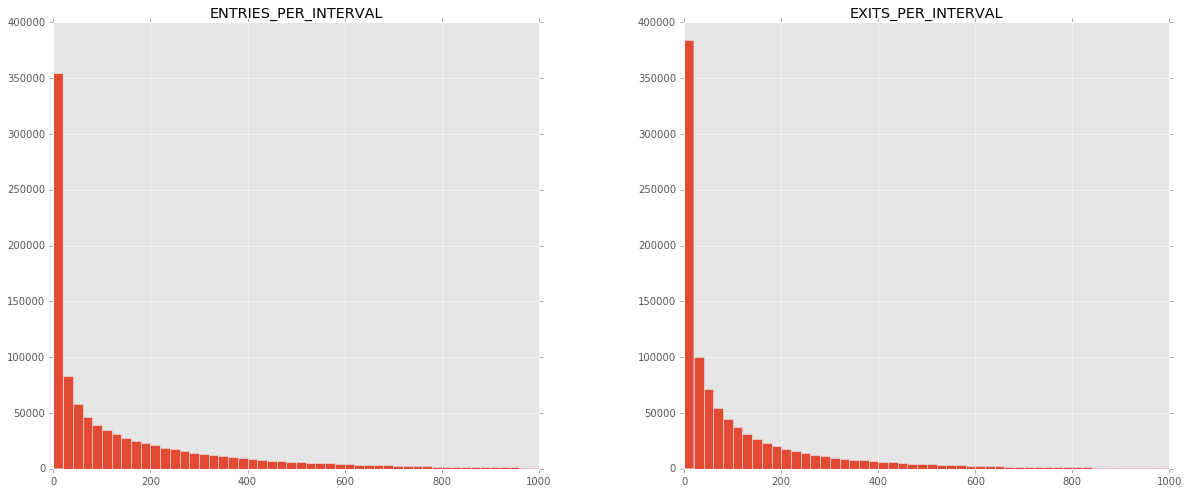

In [16]:
plt.figure()
samplesize = 1000000 # 1 million
histparams = { 'bins':50, 'range':(0,1000), 'figsize':(20, 8) }
df_samples = df.sample(n=samplesize).loc[:,['EXITS_PER_INTERVAL','ENTRIES_PER_INTERVAL']]
df_samples.hist(**histparams)

### To further show this extreme distribution of per_interval data let's plot it using a boxplot with a *log scale x axis*

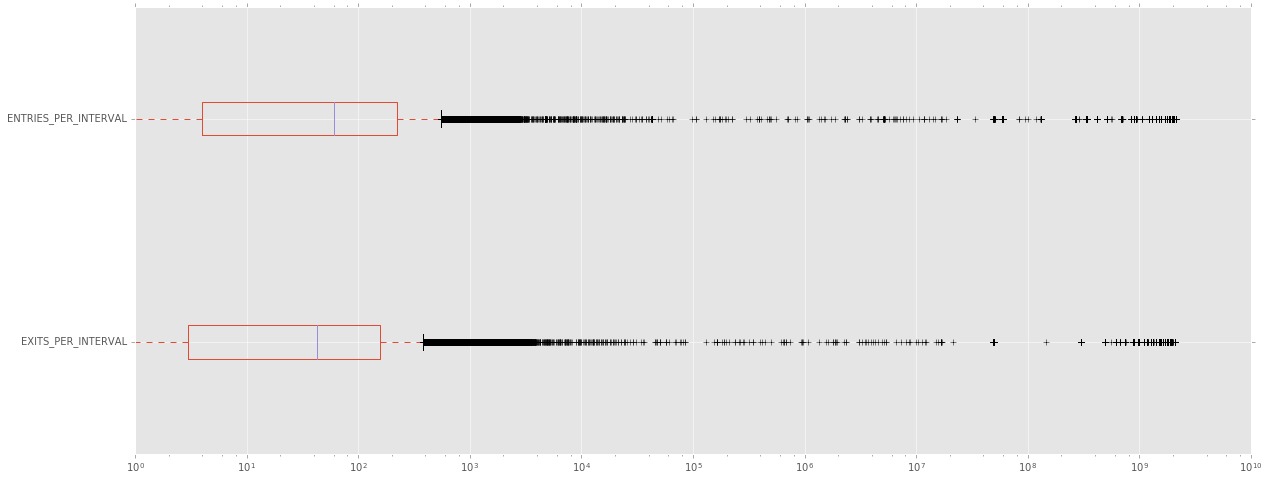

In [17]:
plt.figure()
df_samples.plot.box(vert=False, figsize=(20, 8), logx=True)

### It's clear per_interval counts drop *very* rapidly and 1000 is clearly a *more than safe* cap choice.
### Let's just how much data we're losing from capping.

In [6]:
def perc_of_total_data(df_new,df_old):
    '''see how much cleaning a dataset reduced its size'''
    return float(df_new.shape[0]) / df_old.shape[0]

In [19]:
cap = 1000
for col in ['ENTRIES_PER_INTERVAL','EXITS_PER_INTERVAL']:
    df_above_cap = df[df[col] > cap]
    print('capping {} to < {}, results in removing {:.1%} of our data'.format(
            col, cap, perc_of_total_data(df_above_cap, df)))

capping ENTRIES_PER_INTERVAL to < 1000, results in removing 1.9% of our data
capping EXITS_PER_INTERVAL to < 1000, results in removing 1.4% of our data


### Now that we've justified removing outliers, let's cap the per_interval columns

In [20]:
for col in ['ENTRIES_PER_INTERVAL', 'EXITS_PER_INTERVAL']:
    df.ix[df[col] > cap, col] = np.nan

### Check for negative per_interval values and if they exists, simply change them to NaN's

In [21]:
print('number of rows below zero:', 
      df[df.ENTRIES_PER_INTERVAL < 0].shape[0], 
      'and', 
      df[df.EXITS_PER_INTERVAL < 0].shape[0])

number of rows below zero: 22 and 17


In [22]:
for col in ['ENTRIES_PER_INTERVAL', 'EXITS_PER_INTERVAL']:
    df.ix[df[col] < 0, col] = np.nan

### Create a column for busyness: entries + exits

In [23]:
# this is now very easy given we have <ENTRIES/EXITS>_PER_INTERVAL
df['BUSYNESS_PER_INTERVAL'] = df.ENTRIES_PER_INTERVAL + df.EXITS_PER_INTERVAL

### Add granular date information which will come in handy for modeling and analysis

In [24]:
# add any date information that might be important for modeling
# do now so we don't have to redo everytime we tweak our model
df['MINUTE'] = df['DATETIME'].dt.minute
df['HOUR'] = df['DATETIME'].dt.hour
df['MONTH'] = df['DATETIME'].dt.month
df['YEAR'] = df['DATETIME'].dt.year
df['DAYOFWEEK'] = df['DATETIME'].dt.dayofweek
df['DAYOFYEAR'] = df['DATETIME'].dt.dayofyear
df['WEEKOFYEAR'] = df['DATETIME'].dt.weekofyear

### Save single, large, augmented dataframe

In [25]:
save_df(df, 'turnstile', 'augmented')

In [29]:
# check size of pickled augmented dataframe
!du -sh augmented

12G	augmented


# Data analysis

In [8]:
from datetime import datetime, timedelta

df = pd.read_pickle('augmented/turnstile')

### 1. What is the total number of entries & exits across the subway system for August 1, 2013?

In [7]:
from datetime import datetime

# grab data that lies within the day and sort by datetime
range_augfirst = (df.DATETIME >= datetime(2013, 8, 1)) & \
                 (df.DATETIME <  datetime(2013, 8, 2))
df_augfirst = df[range_augfirst]
print("Total traffic numbers for August 1st, 2013")
print("Entries {:,}".format(df_augfirst.ENTRIES_PER_INTERVAL.sum()))
print("Exits   {:,}".format(df_augfirst.EXITS_PER_INTERVAL.sum()))

Total traffic numbers for August 1st, 2013
Entries 4,731,028.0
Exits   3,706,783.0


### 2. Let's define the busy-ness as sum of entry & exit count. What station was the busiest on August 1, 2013? What turnstile was the busiest on that date?

In [8]:
df_augfirst_sum_on_station = df_augfirst.groupby('STATION').sum()
print("The busiest station was {} and saw traffic of {:,}".format(
        df_augfirst_sum_on_station.BUSYNESS_PER_INTERVAL.idxmax(),
        df_augfirst_sum_on_station.BUSYNESS_PER_INTERVAL.max()))
df_augfirst_sum_on_turnstile = df_augfirst.groupby('TURNSTILE').sum()
busiest_turnstile = df_augfirst_sum_on_turnstile.BUSYNESS_PER_INTERVAL.idxmax()
busiest_turnstile_station = df_augfirst[df_augfirst.TURNSTILE==busiest_turnstile].STATION.iloc[0]
print("The busiest turnstile was {} at {} and saw traffic of {:,}".format(
        busiest_turnstile,
        busiest_turnstile_station,
        df_augfirst_sum_on_turnstile.BUSYNESS_PER_INTERVAL.max()))

The busiest station was 34 ST-PENN STA and saw traffic of 230,767.0
The busiest turnstile was R221-R170-01-03-02 at 14 ST-UNION SQ and saw traffic of 6,823.0


### 3. What were the busiest and least-busy stations in the system over all of July 2013?

In [9]:
# get data within July and sum on station groups
range_july = (df.DATETIME >= datetime(2013, 7, 1)) & \
             (df.DATETIME <  datetime(2013, 8, 1))
df_july = df[range_july]
df_july_sum_by_station = df_july.groupby('STATION').sum()
print("The busiest station was {} and saw traffic of {:,}".format(
        df_july_sum_by_station.BUSYNESS_PER_INTERVAL.idxmax(),
        df_july_sum_by_station.BUSYNESS_PER_INTERVAL.max()))
print("The least-busy station was {} and saw traffic of {:,}".format(
        df_july_sum_by_station.BUSYNESS_PER_INTERVAL.idxmin(),
        df_july_sum_by_station.BUSYNESS_PER_INTERVAL.min()))

The busiest station was 34 ST-PENN STA and saw traffic of 6,496,841.0
The least-busy station was AQUEDUCT TRACK and saw traffic of 268.0


### 4. Which station had the highest average number of entries between midnight & 4am on Fridays in July 2013?

In [10]:
fridays = (df.DAYOFWEEK == 4)
# because hour==0 means the count for the previous 4-hr interval, we'll save HOUSE >0 and <=4
midnight_to_four_am = (df.HOUR > 0) & (df.HOUR <= 4)
df_late_night = df[range_july & fridays & midnight_to_four_am]
df_late_night_station_avgs = df_late_night.groupby('STATION').mean()
print("Station {} with average traffic {:,}".format(
    df_late_night_station_avgs.BUSYNESS_PER_INTERVAL.idxmax(),
    df_late_night_station_avgs.BUSYNESS_PER_INTERVAL.max()));

Station W 4 ST-WASH SQ with average traffic 556.144927536


### 5. What stations have seen the most usage growth/decline in the last year?

In [11]:
# grab "last year" which is 2015
range_year = (df.DATETIME >= datetime(2015, 1, 1)) & \
             (df.DATETIME <  datetime(2016, 1, 1))
df_lastyr = df[range_year]

### We are going to calculate percentage growth on a weekly basis, which should help smooth daily outliers

In [12]:
# sum the columns on a station and weekly basis
df_lastyr_by_wk = df_lastyr.groupby(['STATION','WEEKOFYEAR']).sum().reset_index()

# to prevent infinity% change (aka divide by 0), we're going to make all 0.0 BUSYNESS_PER_INTERVAL values 1.0.
# this will have a negligible effect while still showing large percentage growth when the day prior is 0
df_lastyr_by_wk.ix[df_lastyr_by_wk.BUSYNESS_PER_INTERVAL==0, 'BUSYNESS_PER_INTERVAL'] = 1.0

# finally calculate the percent change in busyness from week to week
df_lastyr_by_wk['BUSYNESS_PERC_CHANGE'] = df_lastyr_by_wk.groupby('STATION').pct_change().BUSYNESS_PER_INTERVAL

### Grab the moving average to further smooth the busyness percent change

In [13]:
# 3 week window for moving average
rolling_mean = lambda ser: ser.rolling(window=4, center=True).mean()
df_lastyr_by_wk['BUSYNESS_CHANGE_MOVING_AVG'] = df_lastyr_by_wk.groupby('STATION')['BUSYNESS_PERC_CHANGE'].apply(rolling_mean)

### Find the stations in terms of the mean of the moving percentage change

In [53]:
df_busyness_avgs_sorted = df_lastyr_by_wk.groupby('STATION').mean().sort_values('BUSYNESS_CHANGE_MOVING_AVG')

### 10 Highest Growth Stations in 2015

In [54]:
df_busyness_avgs_sorted.tail(10).loc[:,['BUSYNESS_CHANGE_MOVING_AVG','BUSYNESS_PERC_CHANGE']].iloc[::-1]

,BUSYNESS_CHANGE_MOVING_AVG,BUSYNESS_PERC_CHANGE
STATION,,
34 ST-HUDSON YD,727.118383,630.043025
ORCHARD BEACH,4.687183,5.328780
BUHRE AVE,3.848287,11.182154
ZEREGA AVE,1.083464,2.134389
OXFORD-104 ST,0.116312,0.131526
WINTHROP ST,0.105695,0.144322
BOYD-88 ST,0.093629,0.106030
METS-WILLETS PT,0.092127,0.081699
71 ST,0.083569,0.092029


### Clearly something extreme is happening with 34th Street Hudson Yards. 
### That station opened recently after massive delays and, after closer inspection, I can only wonder why it was alternating between 0 and 1000s in the BUSYNESS_PER_INTERVAL column.
### So I christen the winner to be Orchard Beach with both the highest mean % change and highest mean of the moving-avg of the weekly % change

## 10 Lowest Growth Stations in 2015

In [52]:
df_busyness_avgs_sorted.head(10).loc[:,['BUSYNESS_CHANGE_MOVING_AVG','BUSYNESS_PERC_CHANGE']]

,BUSYNESS_CHANGE_MOVING_AVG,BUSYNESS_PERC_CHANGE
STATION,,
AVENUE X,-0.006548,0.024540
ROCKAWAY AVE,-0.003494,0.010027
57 ST-7 AVE,-0.001180,0.007146
14 ST-UNION SQ,0.000123,0.003215
LEXINGTON AVE,0.001248,0.007664
MIDDLETOWN ROAD,0.001712,0.022728
42 ST-GRD CNTRL,0.002132,0.010717
42 ST-PORT AUTH,0.002365,0.006173
SUTPHIN BLVD,0.002613,0.004482


### Avenue X wins with a negative moving-avg percentage growth

### 6. What dates are the least busy? Could you identify days on which stations were not operating at full capacity or closed entirely?

In [68]:
df_daily_traffic = df.groupby(['YEAR','DAYOFYEAR']).sum().sort_values('BUSYNESS_PER_INTERVAL')
df_daily_traffic.head(10).loc[:,'BUSYNESS_PER_INTERVAL']

YEAR    DAYOFYEAR
2012.0  304.0          13821.0
        305.0          15991.0
2011.0  240.0          19360.0
2012.0  303.0          23058.0
        306.0         370374.0
        307.0         558891.0
2014.0  331.0        1399273.0
        327.0        1722219.0
2013.0  265.0        1810534.0
2014.0  332.0        2011032.0
Name: BUSYNESS_PER_INTERVAL, dtype: float64

### The numbers look extremely low but rows 1, 2, 4, 5, and 6 all correspond to Hurricane Sandy in 2012, while row 3 corresponds to Hurricane Irene in Aug, 2013.

### Get daily totals of busyness and find stations that were not running. Given the distributions are not normal and rather exponential, we we won't subtract the standard deviation from the mean to find outliers but rather take a simple approach and find stations below a reasonable threshold.

In [23]:
df_sum = df.groupby(['STATION','DAYOFYEAR','YEAR']).sum()

(1654, 11)

In [30]:
df_sum[df_sum.BUSYNESS_PER_INTERVAL<=50.0].BUSYNESS_PER_INTERVAL

STATION          DAYOFYEAR  YEAR  
1 AVE            123.0      2015.0    37.0
                 156.0      2011.0    49.0
                 240.0      2011.0    37.0
                 283.0      2010.0    38.0
                 303.0      2012.0    39.0
                 305.0      2012.0     3.0
                 306.0      2012.0     0.0
                 307.0      2012.0    17.0
103 ST           303.0      2012.0    11.0
                 304.0      2012.0    26.0
                 305.0      2012.0    22.0
103 ST-CORONA    240.0      2011.0    16.0
                 303.0      2012.0    34.0
                 304.0      2012.0    35.0
                 305.0      2012.0    13.0
                 306.0      2012.0    26.0
104 ST           76.0       2013.0    16.0
                 83.0       2013.0    10.0
                 86.0       2011.0     9.0
                 90.0       2013.0    20.0
                 93.0       2011.0    20.0
                 97.0       2013.0    29.0
                 10

# Model Turnstile Exit Traffic for a Given Unit and 4-Hour Time Interval

In [9]:
from sklearn import preprocessing, grid_search
from sklearn.cross_validation import KFold
from sklearn.linear_model import SGDRegressor

# read in reformatted, cleaned, augmented dataset
df_clean = pd.read_pickle('augmented/turnstile')

# our model is going to predict exit traffic based on each single hour.
# this will allow us to be more fine grained and robust.
# to find a four-hour interval we will run the model for 4 times and sum the 

# note: unfortunately UNIT's are not unique to STATION's thus can't use STATION's as features.
#       also, since we are using the regular audit times, MINUTE will always be 0 making useless as a feature.
#       last, UNIT's will be added as a matrix of one-hot-encoded vectors.
features = ['HOUR','MONTH','YEAR','DAYOFYEAR','DAYOFWEEK','WEEKOFYEAR']
target = 'EXITS_PER_INTERVAL'

### clean the data before modeling.
# we don't want to take any risks and we have enough data
# to remove potentially harmful / irregular datapoints.

# train only on the regular 4-hr auditing time periods remove irregular audits
regular_times = df_clean.TIME.isin([
    '00:00:00', '04:00:00', '08:00:00', '12:00:00', '16:00:00', '20:00:00'])
reg_audit = (df_clean.DESC == 'REGULAR')
df_clean = df_clean[regular_times & reg_audit]

# reduce to features and target. UNIT will be dropped in a moment
df_clean = df_clean.loc[:,['UNIT']+features+[target]]
# remove rows with NaN values
df_clean = df_clean.dropna()
# drop duplicate rows
df_clean = df_clean.drop_duplicates()

# because of memory limits :( we're going to sample the dataset
sample = int(df_clean.shape[0] / 10.0)
df_clean = df_clean.sample(n=sample)

# pull out target before scaling features
y = df_clean.loc[:,target].as_matrix()
del df_clean[target]

# one-hot-encode UNIT since it's a categorical variables
np_one_hot_encoded = pd.get_dummies(df_clean.UNIT).as_matrix()
del df_clean['UNIT']

# normalize current set of features to have zero mean and unit variance
np_scaled = preprocessing.scale(df_clean)
del df_clean

# get final input X of scaled scalars and one-hot-encoded categories
X = np.concatenate((np_scaled, np_one_hot_encoded), axis=1)
#print('% data retained after cleaning', perc_of_total_data(X,df))

KeyboardInterrupt: 

In [8]:
# setup model. use simple SGD initially
# a major advantage of SGD is its efficiency, which is essentially 
# linear in the number of training examples.
sgdreg = SGDRegressor(
    n_iter= np.ceil(10.0**6 / X.shape[0]), # sklearn recommended
)
parameters = {
    'alpha': 10.0**-np.arange(1,7), # sklearn recommended
    'penalty': ['l2','l1','elasticnet'],
}

import multiprocessing
cores = multiprocessing.cpu_count()

# perform grid search in parallel. unfortunately I need *waaay* more memory to do full 32-core parallel
num_jobs = cores / 16
print('grid search in parallel. num cores used:', num_jobs)

import time
start = time.time()
clf = grid_search.GridSearchCV(sgdreg, parameters, n_jobs=num_jobs, cv=10)
clf.fit(X, y)
print(time.time() - start)

# don't forget to save the model!
from sklearn.externals import joblib
joblib.dump(clf, 'estimators/sgd_full/clf.pkl')

grid search in parallel. num cores used: 2


OSError: [Errno 12] Cannot allocate memory